In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
import scipy.special as sc
from scipy.integrate import odeint
import process_utility as psu
import scipy.integrate as integ
from scipy.optimize import curve_fit
import time

In [2]:
dataLED = psu.read_file('/data/abalone/2021_05_05/SiPM2_32V_ABALONE_12k_LED_10V.dat')
data = psu.read_file('/data/abalone/2021_05_05/SiPM2_32V_ABALONE_12k_NoLED.dat')

/data/abalone/2021_05_05/SiPM2_32V_ABALONE_12k_LED_10V.dat Number of events 59356.0
/data/abalone/2021_05_05/SiPM2_32V_ABALONE_12k_NoLED.dat Number of events 444326.0


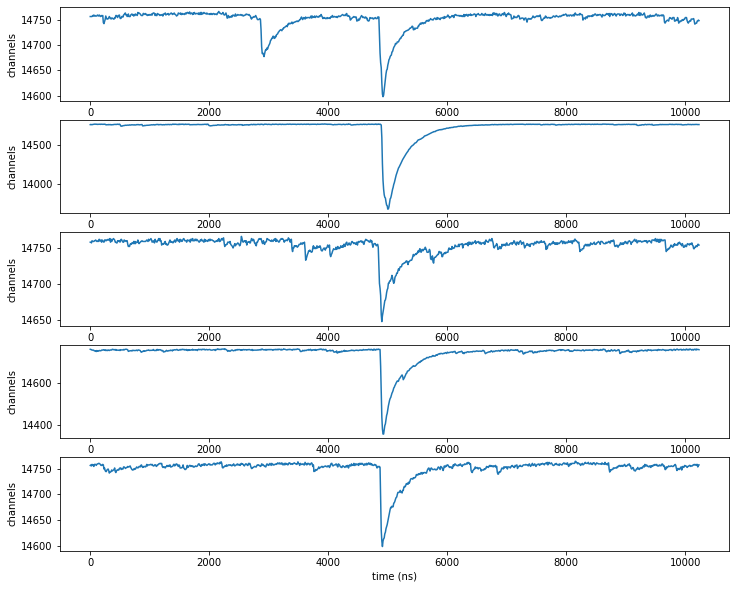

In [3]:
psu.plot_waveforms2( data, events = 5)

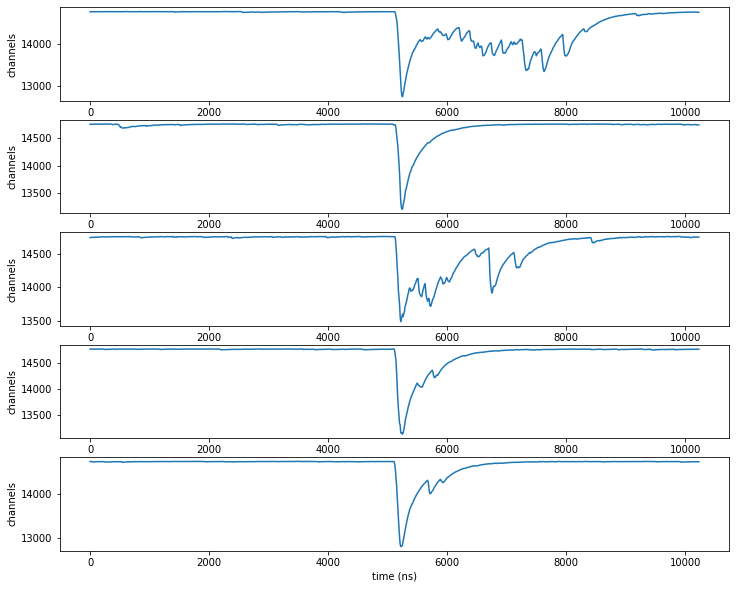

In [4]:
psu.plot_waveforms2( dataLED, events = 5)

In [40]:
def process_abalone_data(data,nn=1000,nplot=5):
    print(f'Total events number: {len(data)}')
    MINs, FOMs, MAXs, INTs, width50 = [], [], [], [], []
    ts = time.time()
    plt.figure(figsize=(12,6))
    if nn == 0: nn = len(data)
    for i in range(nn):
        if (i % 10000) == 0: print(f'event n. {i} time to process: {time.time()-ts:.2f}')
        bl=np.max(data[i][:])
        wf = bl-data[i]
        max_pos = np.where(wf==np.max(wf))[0][0]
        area = np.sum(wf)
        fom = np.sum(wf[max_pos:])/area
        ii, areafrac = 1, 0
        while areafrac < 0.5:
            ilo50, ihi50 = max_pos-ii, max_pos+ii
            areafrac = np.sum(wf[ilo50:ihi50])/area
            ii += 1
            wid50 = ihi50 - ilo50
        MINs.append(bl)
        MAXs.append(np.max(wf))
        FOMs.append(fom)
        INTs.append(area)
        width50.append(wid50)
        if i < nplot: plt.plot(wf,label=f'A={area}, W={wid50}, f.o.m.={fom:.2f}')
    plt.legend()
    return MINs, FOMs, MAXs, INTs, width50

Total events number: 444326
event n. 0 time to process: 0.00
event n. 10000 time to process: 6.11
event n. 20000 time to process: 12.12
event n. 30000 time to process: 18.23
event n. 40000 time to process: 24.34
event n. 50000 time to process: 30.37
event n. 60000 time to process: 36.39
event n. 70000 time to process: 42.40
event n. 80000 time to process: 48.31
event n. 90000 time to process: 54.27
event n. 100000 time to process: 60.32
event n. 110000 time to process: 66.43
event n. 120000 time to process: 72.50
event n. 130000 time to process: 78.48
event n. 140000 time to process: 84.60
event n. 150000 time to process: 90.66
event n. 160000 time to process: 97.11
event n. 170000 time to process: 104.12
event n. 180000 time to process: 111.04
event n. 190000 time to process: 117.77
event n. 200000 time to process: 124.59
event n. 210000 time to process: 131.50
event n. 220000 time to process: 138.29
event n. 230000 time to process: 145.28
event n. 240000 time to process: 152.04
event

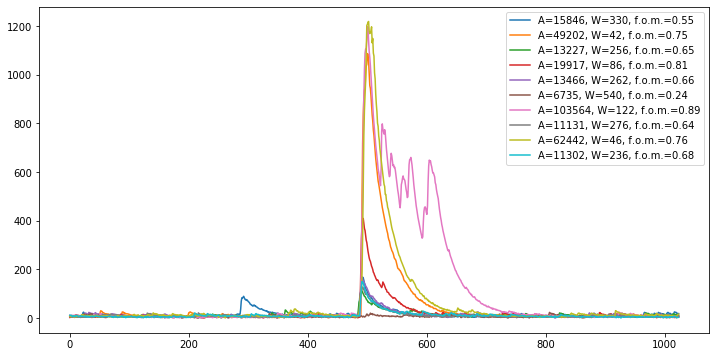

In [41]:
MINs, FOMs, MAXs, INTs, width50 = process_abalone_data(data,nn=0,nplot=10)

Text(0, 1, 'counts')

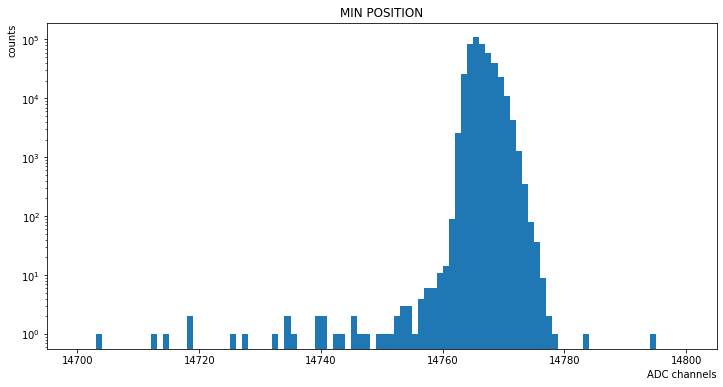

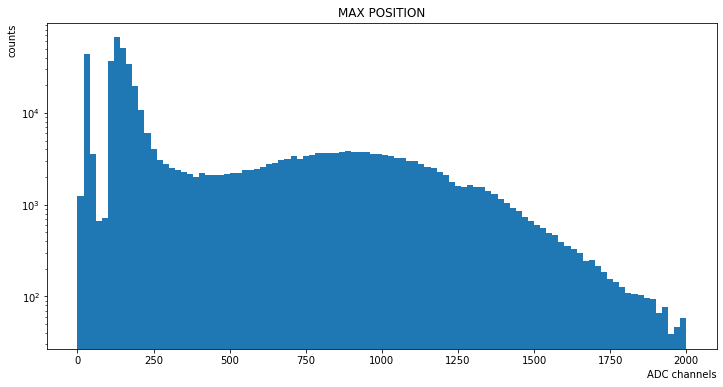

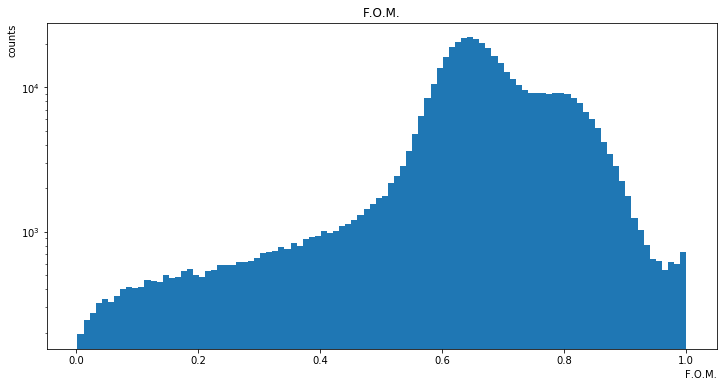

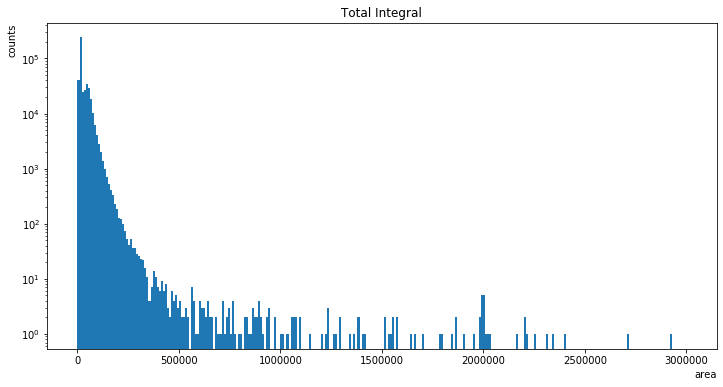

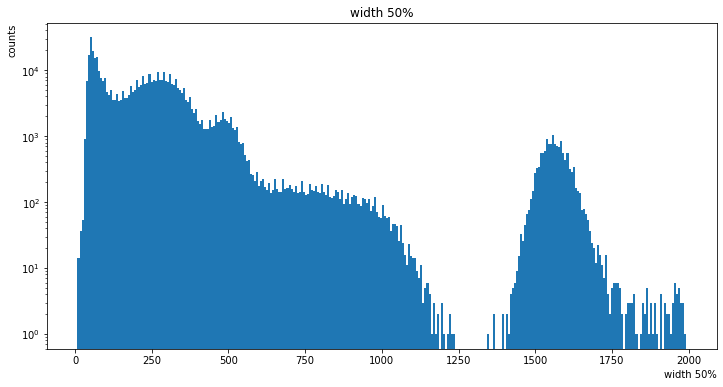

In [42]:
plt.figure(figsize=(12,6))
a=plt.hist(MINs,range=(14700,14800),bins=100)
plt.yscale('log')
plt.title('MIN POSITION')
plt.xlabel('ADC channels',ha='right',x=1)
plt.ylabel('counts',ha='right',y=1)

plt.figure(figsize=(12,6))
a=plt.hist(MAXs,range=(0,2000),bins=100)
plt.yscale('log')
plt.title('MAX POSITION')
plt.xlabel('ADC channels',ha='right',x=1)
plt.ylabel('counts',ha='right',y=1)

plt.figure(figsize=(12,6))
a=plt.hist(FOMs,bins=100)
plt.yscale('log')
plt.title('F.O.M.')
plt.xlabel('F.O.M.',ha='right',x=1)
plt.ylabel('counts',ha='right',y=1)

plt.figure(figsize=(12,6))
a=plt.hist(INTs,bins=300,range=(0,3e6))
plt.yscale('log')
plt.title('Total Integral')
plt.xlabel('area',ha='right',x=1)
plt.ylabel('counts',ha='right',y=1)

plt.figure(figsize=(12,6))
a=plt.hist(width50,bins=300)
plt.yscale('log')
plt.title('width 50%')
plt.xlabel('width 50%',ha='right',x=1)
plt.ylabel('counts',ha='right',y=1)

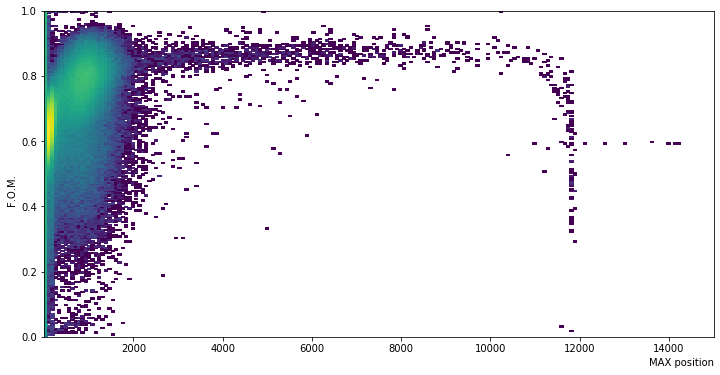

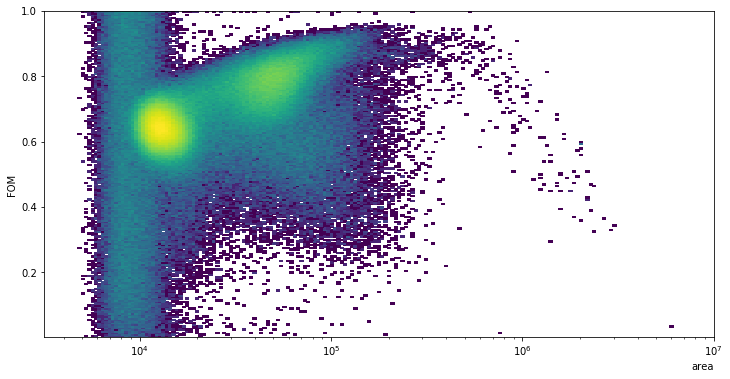

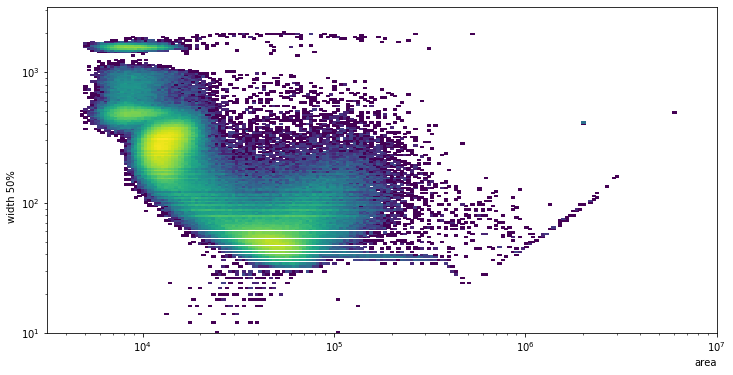

In [53]:
def plot_hist2D(MAXs,FOMs,INTs,width50):
    plt.figure(figsize=(12,6))
    a=plt.hist2d(MAXs,FOMs,range=((1,15000),(0,1)),bins=200,norm=matplotlib.colors.LogNorm())
    plt.xlabel('MAX position',ha='right',x=1)
    plt.ylabel('F.O.M.',ha='right',x=1)
    
    plt.figure(figsize=(12,6))
    a=plt.hist2d(INTs,FOMs,bins=(np.logspace(3.5,7, 200),200),norm=matplotlib.colors.LogNorm())
    plt.xscale('log')
    plt.xlabel('area',ha='right',x=1)
    plt.ylabel('FOM',ha='right',x=1)
    
    plt.figure(figsize=(12,6))
    a=plt.hist2d(INTs,width50,bins=(np.logspace(3.5,7, 200),np.logspace(1,3.5, 200)),norm=matplotlib.colors.LogNorm())
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('area',ha='right',x=1)
    plt.ylabel('width 50%',ha='right',x=1)
plot_hist2D(MAXs,FOMs,INTs,width50)

28899


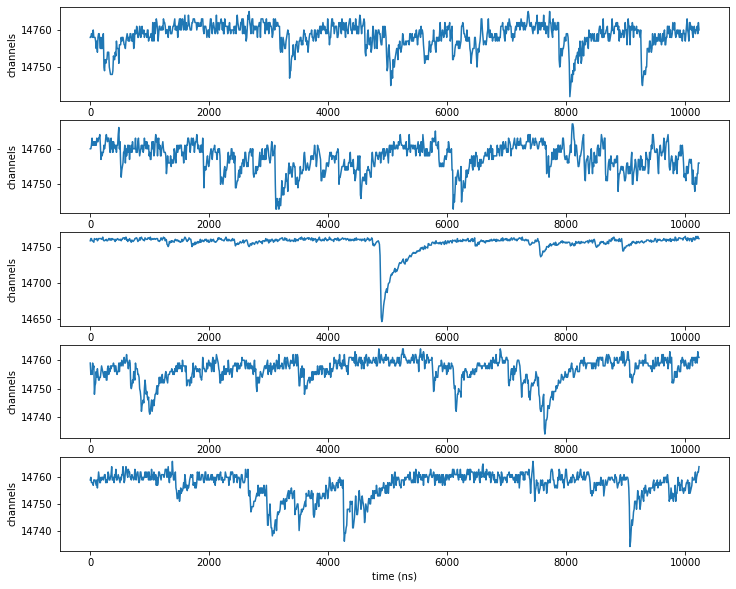

In [50]:
width, area, maxs =np.array(width50), np.array(INTs), np.array(MAXs)
#datacut=data[(MAXs>4000)&(MAXs<10000)]
datacut=data[(width>250)&(width<1250)&(area<1e4)&(maxs<)]
print(len(datacut))
psu.plot_waveforms2( datacut, events = 5)

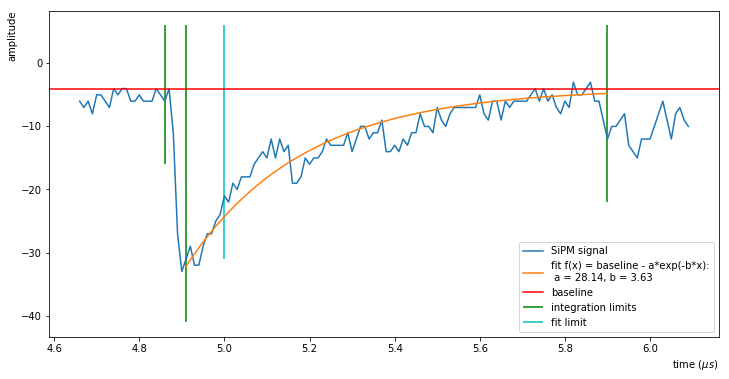

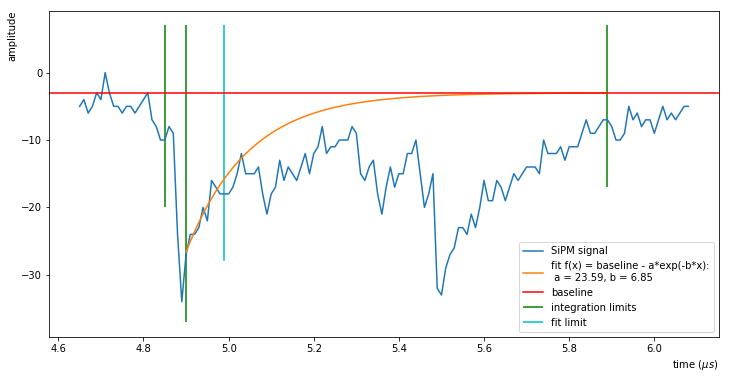

<Figure size 864x432 with 0 Axes>

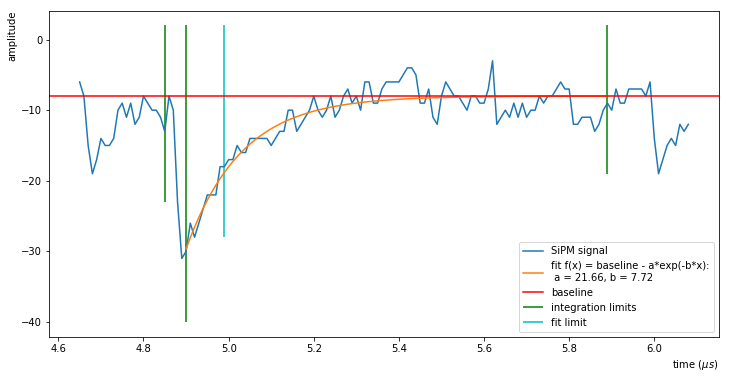

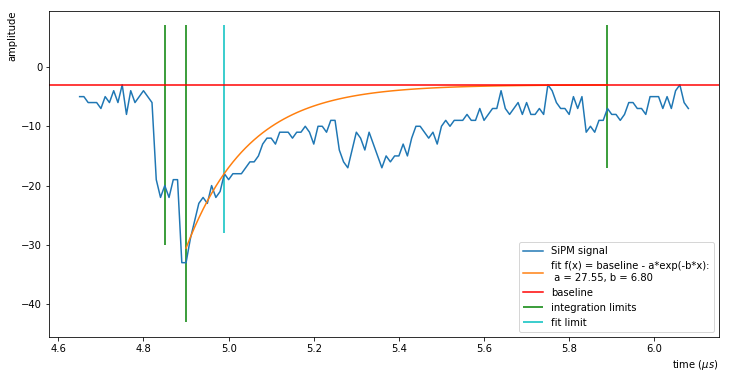

In [14]:
for i in range(5):
    plt.figure(figsize=(12,6))
    listpeaks = psu.search_peaks(data3[i], 4, ampllim = 10, plot = False)
    psu.integral_central_peak(data3[i],listpeaks, dtl=-4, dtr=1, tfit=10,
                              tlim=100,tc=4,tll=8,tlr=10,plot=True)

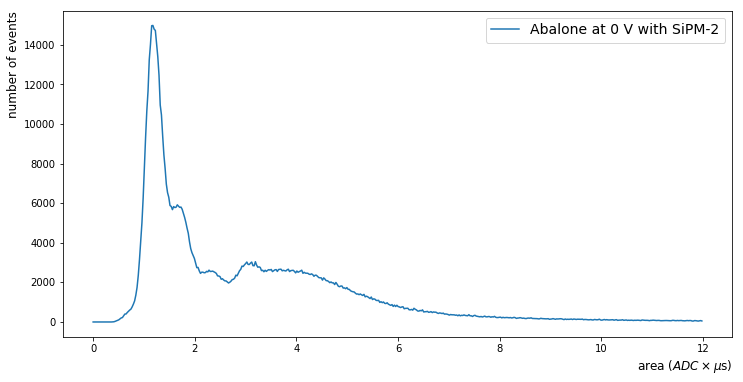

In [16]:
peak_no = np.load(f'2020_12_17/peakint_noAbalone_SiPM2_t15.npy')
plot_spectrum(peak_no, bins = 500, range=(0,12), log = False)

## Joern Abalone and SiPM2 - Low Trigger Threshould

In [17]:
data4 = psu.read_file('/data/abalone/2020_12_17/AbaloneJoern0_SiPM2_t15.dat')

/data/abalone/2020_12_17/AbaloneJoern0_SiPM2_t15.dat Number of events 360096.0


<Figure size 864x432 with 0 Axes>

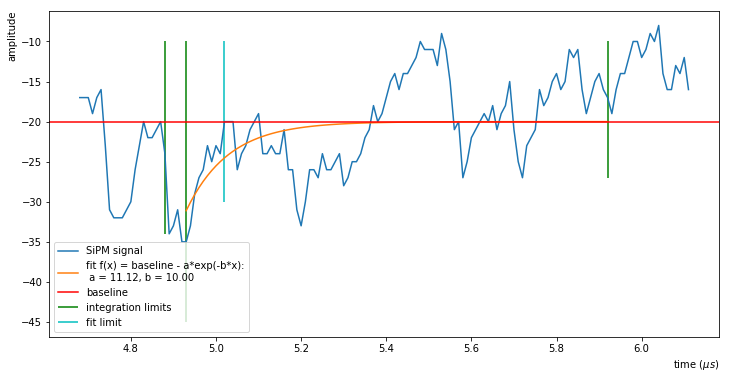

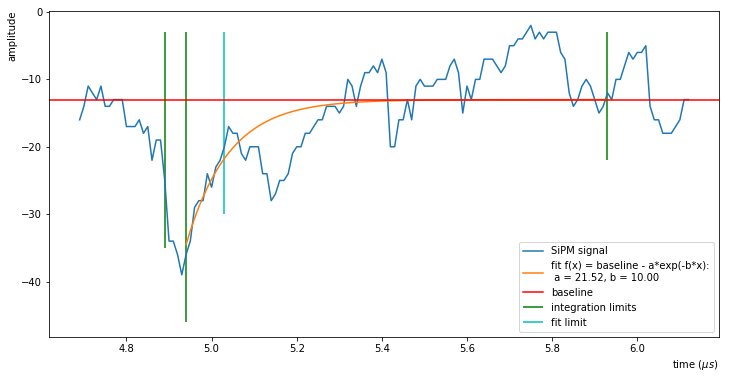

<Figure size 864x432 with 0 Axes>

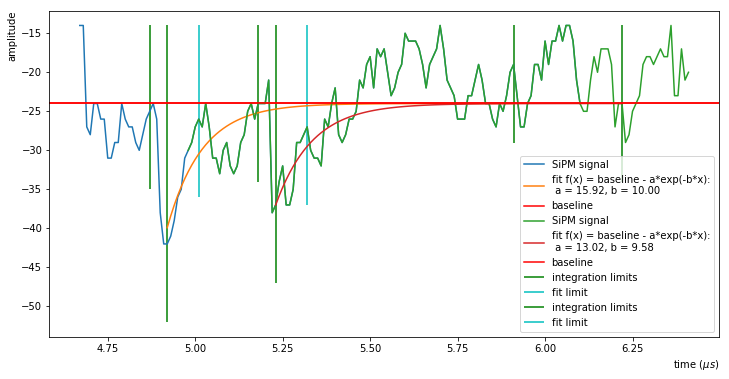

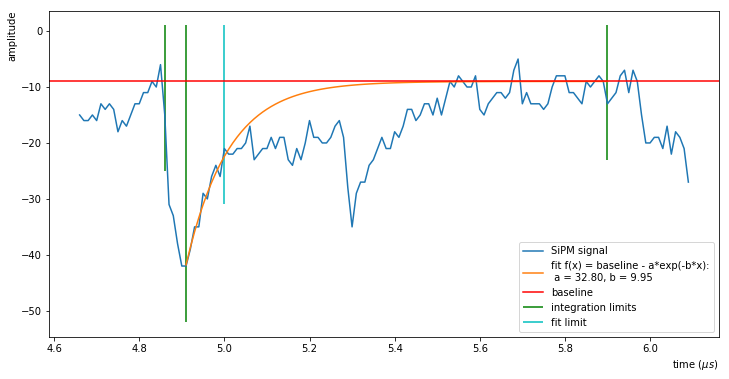

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

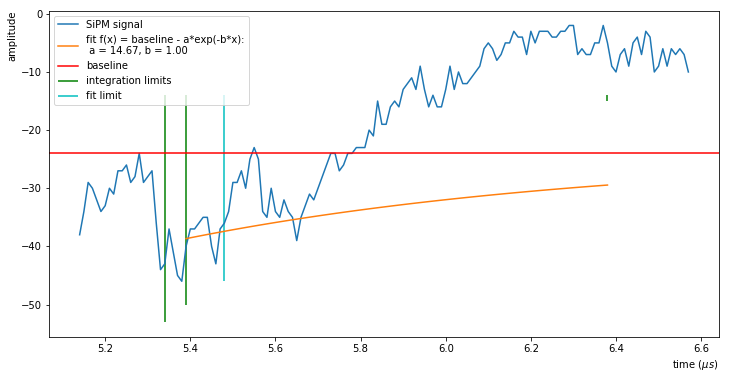

<Figure size 864x432 with 0 Axes>

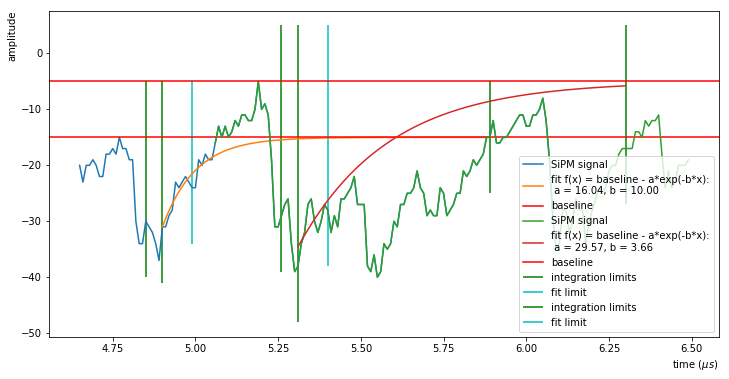

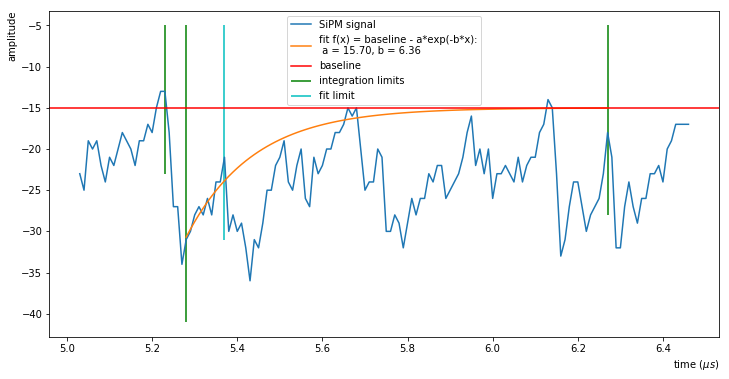

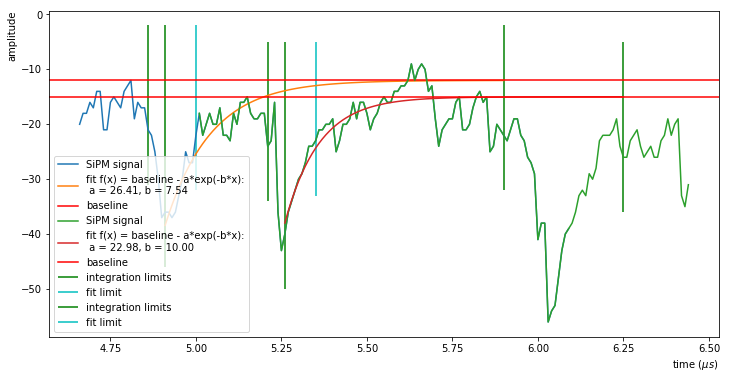

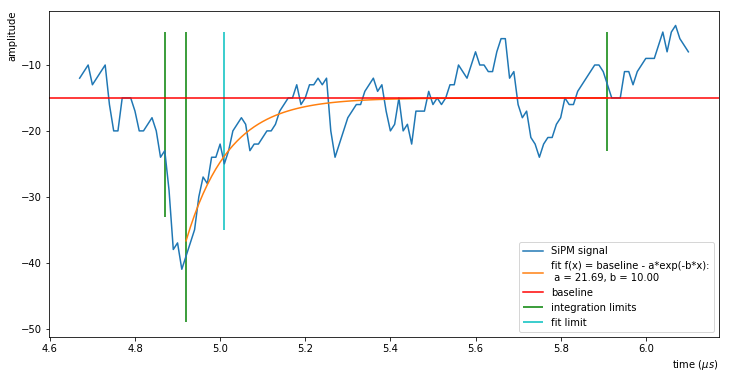

<Figure size 864x432 with 0 Axes>

In [18]:
for i in range(15):
    plt.figure(figsize=(12,6))
    listpeaks = psu.search_peaks(data4[i], 4, ampllim = 10, plot = False)
    psu.integral_central_peak(data4[i],listpeaks, dtl=-4, dtr=1, tfit=10,
                              tlim=100,tc=4,tll=8,tlr=10,plot=True)

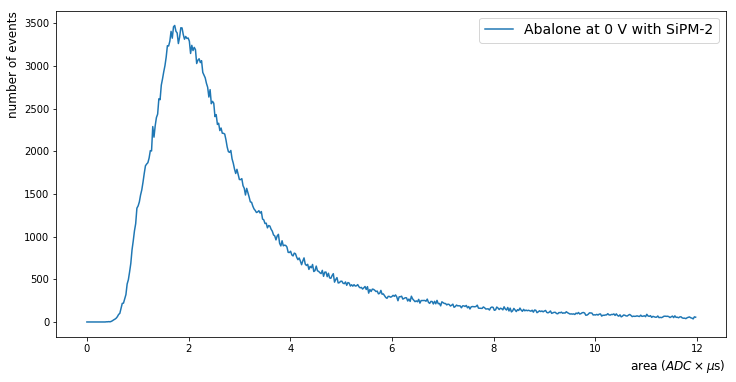

In [24]:
peakJoern15 = np.load(f'2020_12_17/peakint_AbaloneJoern0_SiPM2_t15.npy')
plot_spectrum(peakJoern15, bins = 500, range=(0,12), log = 0)

## Joern Abalone and SiPM2 - High Trigger Threshould

In [20]:
data5 = psu.read_file('/data/abalone/2020_12_17/AbaloneJoern0_SiPM2_t70.dat')

/data/abalone/2020_12_17/AbaloneJoern0_SiPM2_t70.dat Number of events 251629.0


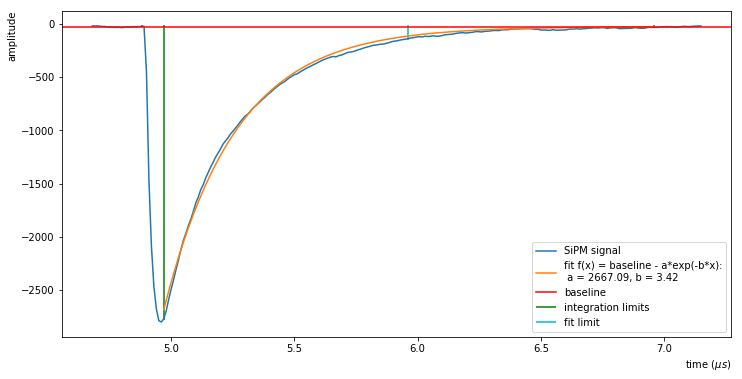

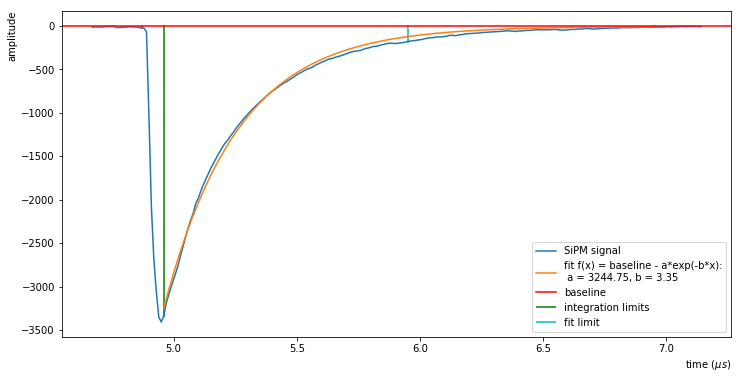

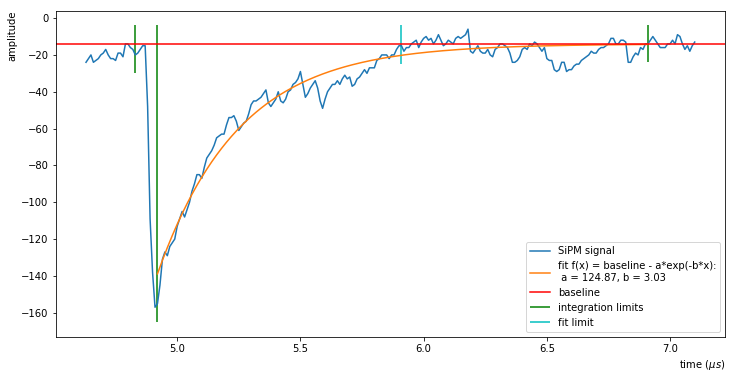

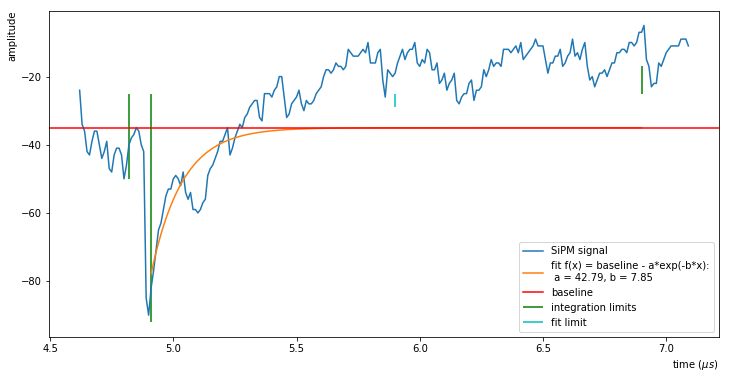

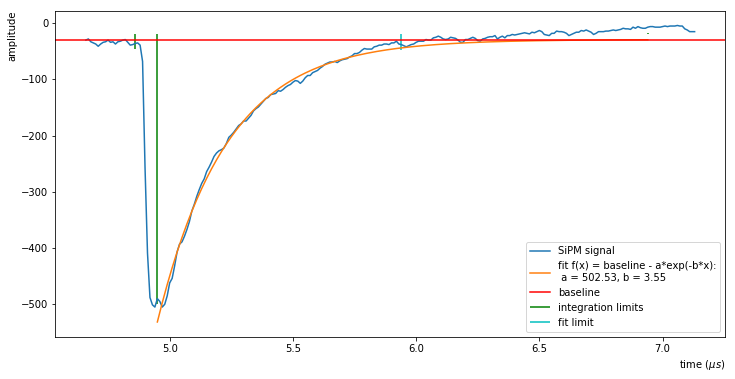

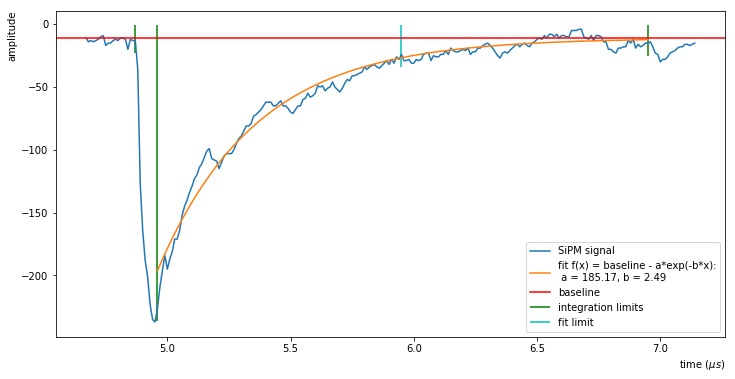

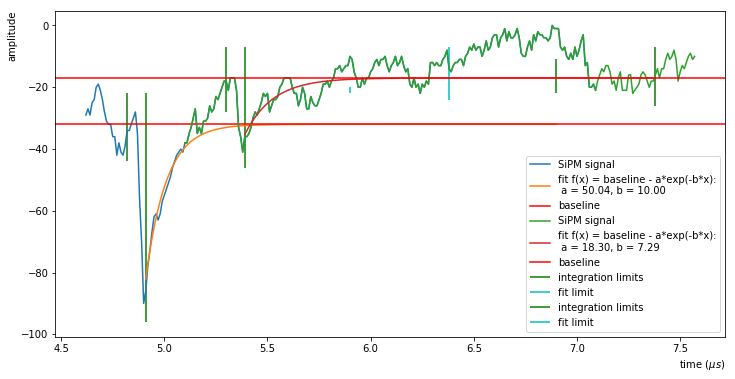

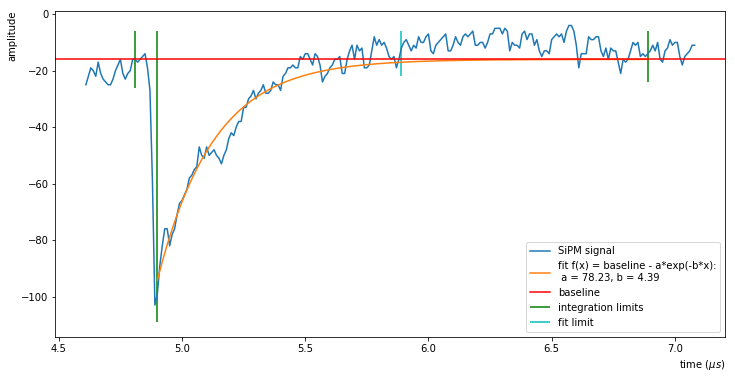

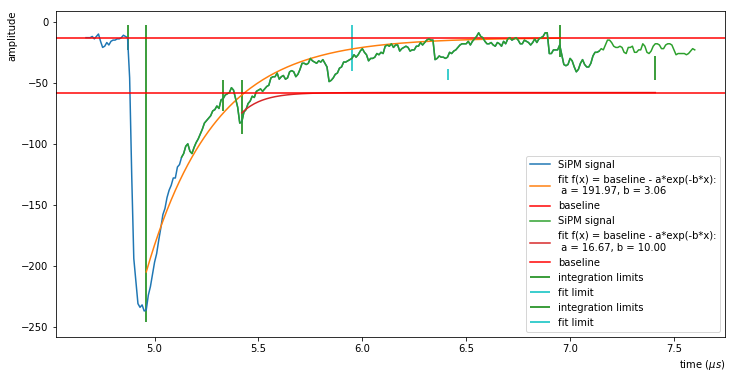

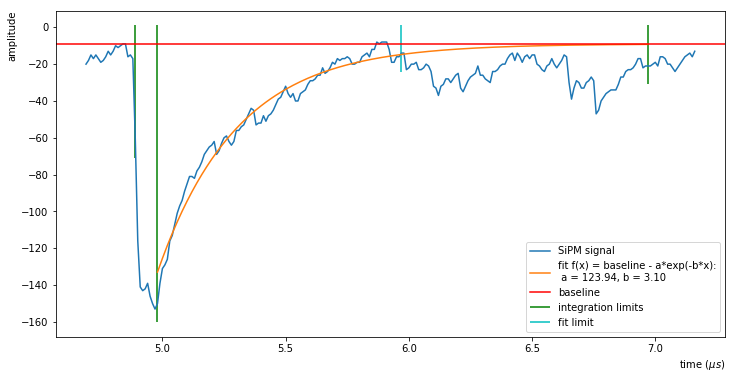

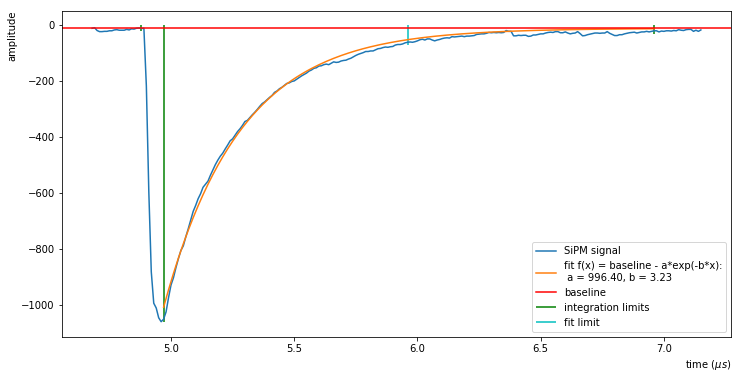

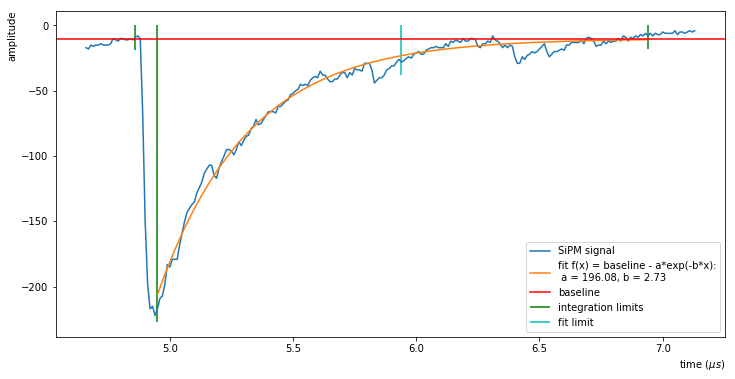

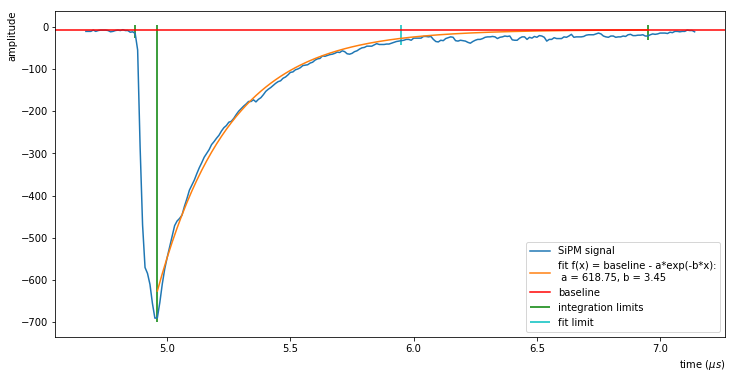

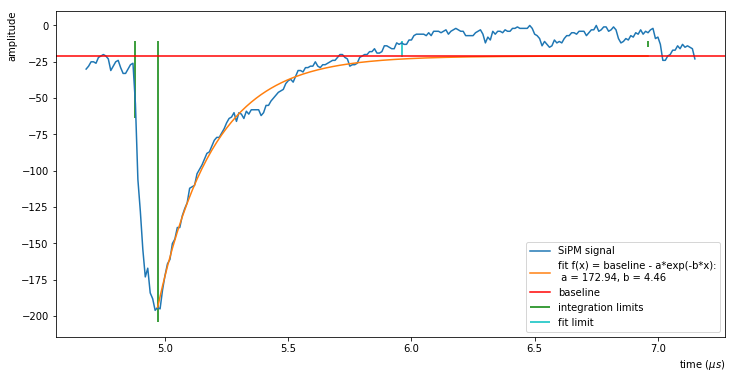

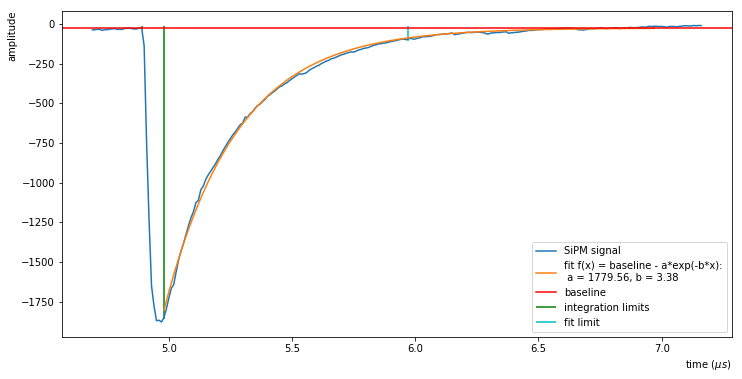

In [21]:
for i in range(15):
    plt.figure(figsize=(12,6))
    listpeaks = psu.search_peaks(data5[i], 4, ampllim = 10, plot = False)
    psu.integral_central_peak(data5[i],listpeaks, dtl=-8, dtr=1, tfit=100,
                              tlim=200,tc=4,tll=8,tlr=10,plot=True)

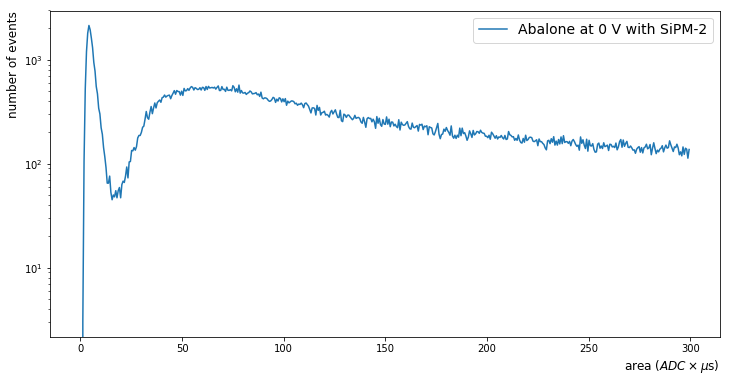

In [25]:
peakJoern70 = np.load(f'2020_12_17/peakint_AbaloneJoern0_SiPM2_t70.npy')
plot_spectrum(peakJoern70, bins = 500, range=(0,300), log = True)

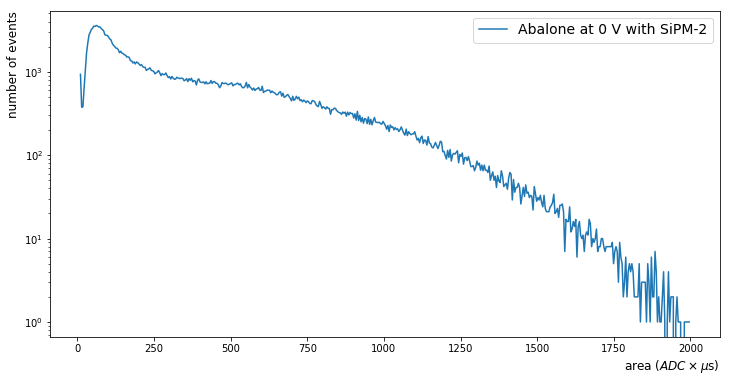

In [26]:
plot_spectrum(peakJoern70, bins = 500, range=(10,2000), log = True)